In this notebook, we study the behavior of heads L18H9, L27H29, and L26H9 on the final token of dontsay prompts.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import prompt_data, utils, ablation

### Load model

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
# tl_model.requires_grad_(False)
with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


### Load facts and develop prompt

In [4]:
irrelevant_words = ["apple", "river", "car", "dog", "house", "tree", "book"]

df = pd.read_csv("../../data/facts.csv")
assert set(df.answer) & set(irrelevant_words) == set()
df

,question,answer,type
0,Tom Brady plays the sport of,football,sport
1,LeBron James plays the sport of,basketball,sport
2,Lionel Messi plays the sport of,football,sport
3,Serena Williams plays the sport of,tennis,sport
4,Michael Phelps competes in the sport of,swimming,sport
...,...,...,...
186,Mick Mars plays the,guitar,instrument
187,John Densmore plays the,drums,instrument
188,Jack Bruce plays the,bass,instrument
189,Lars Ulrich plays the,drums,instrument


In [5]:
def get_dontsay_prompt(question: str, forbidden_word: str):
    return f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You are not allowed to say the forbidden word {forbidden_word}.
<</SYS>>
{question} [/INST] \
"""

idx = 119
question = df.question[idx]
forbidden_words = [irrelevant_words[0], df.answer[idx]]

tl_model.remove_all_hook_fns(including_permanent=True)
for i, forbidden_word in enumerate(forbidden_words):
    prompt = get_dontsay_prompt(question, forbidden_word)
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=tl_model,
        top_k=10,
        n_continuation_tokens=20,
    )
    if i == 0:
        print()

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word apple.
<</SYS>>
The element with atomic symbol Sc is [/INST] 
Rank 0. Logit: 18.89 Prob: 89.84% Tokens: ( 2522) |Sc|and|ium|</s>|
Rank 1. Logit: 15.93 Prob:  4.66% Tokens: (18585) |Sure|!|The|element|with|atomic|symbol|Sc|is|...|(|p|aus|ing|for|dram|atic|effect|)|Sc|and|
Rank 2. Logit: 13.98 Prob:  0.67% Tokens: (  323) |T|in|</s>|
Rank 3. Logit: 13.98 Prob:  0.66% Tokens: (23858) |Symbol|</s>|
Rank 4. Logit: 13.87 Prob:  0.59% Tokens: (  317) |S|od|ium|</s>|
Rank 5. Logit: 13.72 Prob:  0.51% Tokens: (20492) |Iron|</s>|
Rank 6. Logit: 13.69 Prob:  0.50% Tokens: (16419) |Thor|ium|</s>|
Rank 7. Logit: 13.46 Prob:  0.39% Tokens: ( 3767) |Str|ont|ium|</s>|
Rank 8. Logit: 13.13 Prob:  0.29% Tokens: (27620) |Lith|ium|</s>|
Rank 9. Logit: 12.98 Prob:  0.24% Tokens: ( 3685) |Sam|arium|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single

### Compute and plot head contributions

In [84]:
labels = None
log_bf_ats = []
for idx in tqdm(range(len(df))):
    question = df.question[idx]
    answer = df.answer[idx]
    # irrelevant_word =  irrelevant_words[idx % len(irrelevant_words)]
    irrelevant_word = irrelevant_words[0]

    prompt_base = get_dontsay_prompt(question, irrelevant_word)
    prompt_comp = get_dontsay_prompt(question, answer)

    with torch.no_grad():
        pd_base = prompt_data.PromptData.get_data(prompt_base, tl_model)
        pd_comp = prompt_data.PromptData.get_data(prompt_comp, tl_model)

    ld = prompt_data.attribution_patch(
        # pd=pd_comp,
        pd=pd_base,
        tl_model=tl_model,
        # ablation_cache=pd_base.cache,
        ablation_cache=pd_comp.cache,
        metric=lambda logits: logits[-1]
        .softmax(dim=-1)
        .logit()[pd_base.ml_token],
    )

    neg_log_bf_id, labels = ld.get_logits_and_labels()
    log_bf_id = -neg_log_bf_id

    labels = labels
    log_bf_ats.append(log_bf_id[:, 0].detach().cpu().numpy())

log_bf_ats = np.stack(log_bf_ats)

  0%|          | 0/191 [00:00<?, ?it/s]

In [85]:
log_bf_means = log_bf_ats.mean(axis=0)

utils.plot_head_data(
    lines=[
        (f"log_bf_means", log_bf_means / np.log(10), labels),
    ],
    spacing=32,
    title="dontsay competing, multi-component ablation",
    yaxis_title="Log_10 Odds",
    xaxis_title="Ablated Components (cumulative)",
    height=420, width=800
).show()

[(0.68788844, 'L31MLP'), (0.6417823, 'L18H9ATN'), (0.3686441, 'L26H9ATN'), (0.34459025, 'L27H29ATN'), (0.19710928, 'L30MLP'), (0.13066962, 'L15H10ATN'), (0.13058475, 'L19H27ATN'), (0.121219866, 'L28H7ATN'), (0.11964184, 'L25H12ATN'), (0.11943077, 'L31H27ATN')]


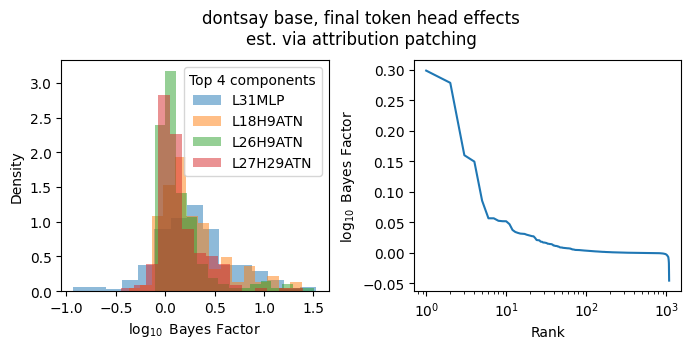

In [90]:
reverse = True
log_bf_x_label = sorted(list(zip(log_bf_means, labels)), reverse=reverse)
print(log_bf_x_label[:10])

plt.figure(figsize=(8, 3))
plt.subplots_adjust(wspace=0.32)
plt.suptitle(
    "dontsay base, final token head effects"
    + "\n"
    + "est. via attribution patching",
    y=1.05,
)

plt.subplot(1, 2, 1)
# plt.hist(log_bf_means / np.log(10), bins=100, density=True)
for _, label in log_bf_x_label[:4]:
    idx = labels.index(label)
    plt.hist(
        log_bf_ats[:, idx] / np.log(10),
        label=label,
        bins=15,
        density=True,
        alpha=0.5,
    )

plt.xlabel("$\log_{10}$ Bayes Factor")
plt.ylabel("Density")
plt.legend(title="Top 4 components")

plt.subplot(1, 2, 2)
plt.plot(
    np.arange(len(log_bf_means)) + 1,
    np.sort(log_bf_means)[::-1 if reverse else 1] / np.log(10),
)
plt.xscale("log")
plt.xlabel("Rank")
plt.ylabel("$\log_{10}$ Bayes Factor")

plt.show()

### Check for component / non-basis alignment
Question, given a bunch of activations,
how can you check for the degree of superposition in that set of activations?

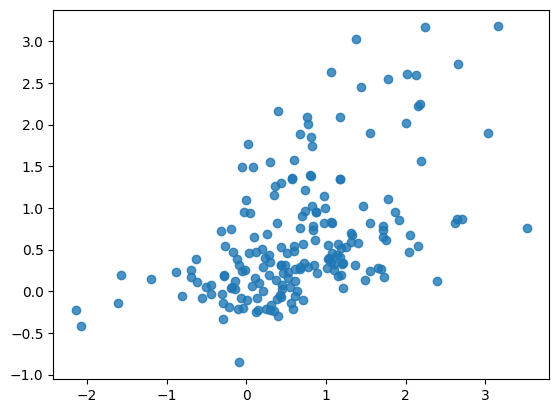

In [93]:
lab1 = "L31MLP"
lab2 = "L18H9ATN"
# lab2 = "L26H9ATN"
# lab2 = "L27H29ATN"

bfs1 = log_bf_ats[:, labels.index(lab1)]
bfs2 = log_bf_ats[:, labels.index(lab2)]

plt.scatter(bfs1, bfs2, alpha=0.8)
plt.show()

### Check effect of ablating top 3 attention heads all at once

In [98]:
metrics = []
for idx in tqdm(range(len(df))):
    question = df.question[idx]
    answer = df.answer[idx]
    # irrelevant_word = irrelevant_words[idx % len(irrelevant_words)]
    irrelevant_word = irrelevant_words[0]

    prompt_base = get_dontsay_prompt(question, irrelevant_word)
    prompt_comp = get_dontsay_prompt(question, answer)

    with torch.no_grad():
        pd_base = prompt_data.PromptData.get_data(prompt_base, tl_model)
        pd_comp = prompt_data.PromptData.get_data(prompt_comp, tl_model)

        pd_orig = pd_base
        pd_patch = pd_comp

        final_logits = ablation.run_with_ablation(
            tl_model=tl_model,
            prompt=pd_orig.prompt,
            ablation_cache=pd_patch.cache,
            attn_head_locs=[
                (18, 9, -1),
                (26, 9, -1),
                (27, 29, -1),
            ],
            # mlp_head_locs=[(31, -1)],
            return_type="logits",
        )[0, -1]

    # tok = tl_model.to_tokens(answer, prepend_bos=False)[0, 0].item()
    tok = pd_base.ml_token
    orig_log_prob = pd_orig.final_logits.log_softmax(dim=-1)[tok]
    ablated_log_prob = final_logits.log_softmax(dim=-1)[tok]

    metrics.append(
        dict(
            orig_log_prob=orig_log_prob.item(),
            ablated_log_prob=ablated_log_prob.item(),
        )
    )

  0%|          | 0/191 [00:00<?, ?it/s]

0.0007584029977537682 0.99995970888311


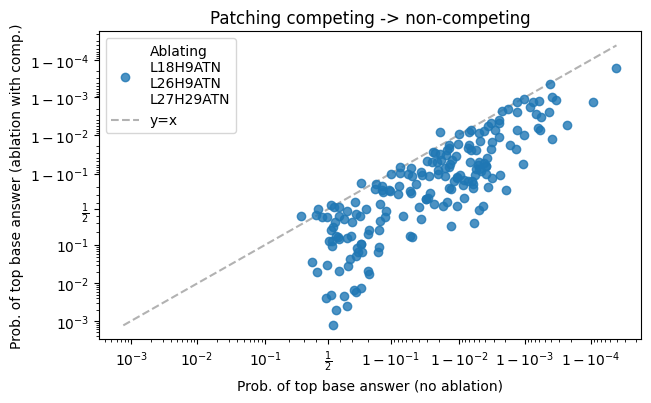

In [100]:
mdf = pd.DataFrame(metrics)

orig_probs = np.exp(mdf.orig_log_prob)
ablated_probs = np.exp(mdf.ablated_log_prob)

minval = min(orig_probs.min(), ablated_probs.min())
maxval = max(orig_probs.max(), ablated_probs.max())
print(minval, maxval)

plt.figure(figsize=(7, 4))
plt.scatter(
    orig_probs,
    ablated_probs,
    alpha=0.8,
    label="Ablating\nL18H9ATN\nL26H9ATN\nL27H29ATN",
)
plt.plot(
    [minval, maxval],
    [minval, maxval],
    color="black",
    linestyle="--",
    alpha=0.3,
    zorder=-1,
    label="y=x",
)
plt.xscale("logit")
plt.yscale("logit")

plt.xlabel("Prob. of top base answer (no ablation)")
plt.ylabel("Prob. of top base answer (ablation with comp.)")
plt.title("Patching competing -> non-competing")

# Legend on outside top left
plt.legend()

plt.show()

### Where does the incorrect answer come from on the forbidden run?

In [ ]:
metrics = []
for idx in tqdm(range(len(df))):
    question = df.question[idx]
    answer = df.answer[idx]
    # irrelevant_word = irrelevant_words[idx % len(irrelevant_words)]
    irrelevant_word = "apple"

    prompt_base = get_dontsay_prompt(question, irrelevant_word)
    prompt_comp = get_dontsay_prompt(question, answer)

    with torch.no_grad():
        pd_base = prompt_data.PromptData.get_data(prompt_base, tl_model)
        pd_comp = prompt_data.PromptData.get_data(prompt_comp, tl_model)

    if pd_base.ml_token == pd_comp.ml_token:
        continue

    # Get sorted indices of pd_base.final_logits
    sorted_tokens = list(
        pd_base.final_logits.argsort(descending=True).cpu().numpy()
    )
    idx_of_comp_ml_token = sorted_tokens.index(pd_comp.ml_token)
    sorted_tokens = sorted_tokens[: idx_of_comp_ml_token + 1]

    if len(sorted_tokens) < 12:
        print(f"SUCCESS {idx}:", end=" ")
    else:
        print(f"FAILURE {idx}:", end=" ")
    print(" ".join([tl_model.to_string(tok) for tok in sorted_tokens]))

  0%|          | 0/191 [00:00<?, ?it/s]

SUCCESS 0: Football FO football Foot NFL Foot " Fo Baseball
SUCCESS 2: Football Soccer
SUCCESS 3: Tennis tennis T " Sure
SUCCESS 5: Track Running Athletics
SUCCESS 6: Baseball baseball B Base Ball Base "
SUCCESS 8: Football Soccer
SUCCESS 9: Tennis tennis T " Sure R Ten Vol W Ven Bad
FAILURE 10: Hockey hockey H Ice " HO Baseball Sure ice Football Ho Hmm Washington Basketball Okay Soccer Hat ** Hu Hero Hey Haw I Go Sports Hello Hum B Great Yes GO P Oh N G * Base Ah ockey Hem ' O Moscow ice Here хо Hand occer K W Hob E Hel Hab Hil Hus Hit HE S Hun Tennis ` Хо HO baseball Hon Lac
SUCCESS 11: Hockey hockey Ice
SUCCESS 12: Basketball basketball B Baseball
SUCCESS 13: Football Soccer
FAILURE 14: Tennis tennis T " Ten Sure R ATP Soccer Roger Feder Football
FAILURE 15: Tennis tennis " T Ten ATP Sure Basketball Soccer Feder Ts Bad
SUCCESS 16: Soccer Football
SUCCESS 19: Snow Ski
SUCCESS 20: Baseball baseball Base Ball " B Base Sure
SUCCESS 22: Football football FO " Foot Foot NFL Baseball
SUCCE